# Sumário

[Funções de Ativação](#Funções-de-Ativação)

[Funções Auxiliares](#Funções-Auxiliares)

[Funções de Custo](#Funções-de-Custo)

[Inicialização de Pesos](#Inicialização-de-Pesos)

[Regularização](#Regularização)

[Learning Rate Decay](#Learning-Rate-Decay)

[Batch Normalization](#Batch-Normalization)

[Batch Generator](#Batch-Generator)

[Implementação](#Implementação)

[Testes da Implementação](#Testes-da-Implementação)

- [Exemplos do Notebook da Intuição](#Exemplos-do-Notebook-da-Intuição)

- [Regressão](#Regressão)
    - [Regressão Linear Simples](#Regressão-Linear-Simples---Exemplo-do-Perceptron)
    - [Regressão Linear Multivariada](#Regressão-Linear-Multivariada---Exerc%C3%ADcio-de-Regressão-do-Perceptron)
    - [Regressão Quadrática](#Regressão-Quadrática)
    - [Regressão Cúbica](#Regressão-Cúbica)
    - [Regressão Logarítimica](#Regressão-Logar%C3%ADtimica)
    - [Regressão Exponencial](#Regressão-Exponencial)

- [Classificação Binária](#Classificação-Binária)
    - [Porta AND/OR](#Porta-AND/OR)
    - [Porta XOR](#Porta-XOR)
    - [2 Clusters](#2-Clusters)
    - [4 Clusters](#4-Clusters)
    - [Círculos](#C%C3%ADrculos)
    - [Moons](#Moons)
    - [Espiral](#Espiral)
    
- [Classificação Multiclasse](#Classificação-Multiclasse)
    - [3 Clusters Multiclasse](#3-Clusters-Multiclasse)
    - [4 Clusters Multiclasse](#4-Clusters-Multiclasse)
    - [Espiral - 5 Classes](#Espiral---5-Classes)
    - [Make Classification - 4 Classes](#Make-Classification---4-Classes)
    - [Iris Dataset](#Iris-Dataset)

[Referências](#Referências)

# Imports and Configurações

In [1]:
import numpy as np
import _pickle as pkl
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs, make_circles, make_moons, make_classification
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import plot
from utils.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10
from utils.grad_check import gradient_checking

%matplotlib inline

# Funções de Ativação

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y * (1 - y)
    return 1.0 / (1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    alpha = 0.1
    if derivative:
        return np.where(x <= 0, alpha, 1)
    return np.where(x <= 0, alpha*x, x)

def elu(x, derivative=False):
    alpha = 1.0
    if derivative:
        y = elu(x)
        return np.where(x <= 0, y + alpha, 1)
    return np.where(x <= 0, alpha*(np.exp(x) - 1), x)

# Funções Auxiliares

In [3]:
def softmax(x, y_oh=None, derivative=False):
    if derivative:
        y_pred = softmax(x)
        k = np.nonzero(y_pred * y_oh)
        pk = y_pred[k]
        y_pred[k] = pk * (1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp / np.sum(exp, axis=1, keepdims=True)

# Funções de Custo

###### Para Regressão

In [4]:
def mae(y, y_pred, derivative=False):
    if derivative:
        return np.where(y_pred > y, 1, -1) / y.shape[0]
    return np.mean(np.abs(y - y_pred))

def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / y.shape[0]
    return 0.5*np.mean((y - y_pred)**2)

###### Para Classificação Binária

In [5]:
def binary_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])
    return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

def sigmoid_cross_entropy(y, y_pred, derivative=False):
    y_sigmoid = sigmoid(y_pred)
    if derivative:
        return -(y - y_sigmoid) / y.shape[0]
    return -np.mean(y * np.log(y_sigmoid) + (1 - y) * np.log(1 - y_sigmoid))

###### Para Classificação Multiclasse

In [6]:
def neg_log_likelihood(y_oh, y_pred, derivative=False):
    k = np.nonzero(y_pred * y_oh)
    pk = y_pred[k]
    if derivative:
        y_pred[k] = (-1.0 / pk)
        return y_pred
    return np.mean(-np.log(pk))

def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    if derivative:
        return -(y_oh - y_softmax) / y_oh.shape[0]    
    return neg_log_likelihood(y_oh, y_softmax)

# Inicialização de Pesos

In [7]:
def zeros(rows, cols):
    return np.zeros((rows, cols))

def ones(rows, cols):
    return np.ones((rows, cols))

def random_normal(rows, cols):
    return np.random.randn(rows, cols)

def random_uniform(rows, cols):
    return np.random.rand(rows, cols)

def glorot_normal(rows, cols):
    # normal com media=0 e stddev=sqrt(2.0 / (out + inp)). Ver notas de np.random.randn.
    std_dev = np.sqrt(2.0 / (rows + cols))
    return std_dev*np.random.randn(rows, cols)

def glorot_uniform(rows, cols):
    # uniforme de [-limit, limit], onde limit = np.sqrt(6.0 / (out + inp))
    limit = np.sqrt(6.0 / (rows + cols))
    return 2*limit*np.random.rand(rows, cols) - limit

# Regularização

In [8]:
def l1_regularization(weights, derivative=False):
    if derivative:
        weights = [np.where(w < 0, -1, w) for w in weights]
        return np.array([np.where(w > 0, 1, w) for w in weights])
    return np.sum([np.sum(np.abs(w)) for w in weights])

def l2_regularization(weights, derivative=False):
    if derivative:
        return weights
    return 0.5 * np.sum(weights**2)

# Batch Generator

In [9]:
def batch_sequential(x, y, batch_size=None):
    batch_size = x.shape[0] if batch_size is None else batch_size
    n_batches = x.shape[0] // batch_size
    
    for batch in range(n_batches):
        offset = batch_size * batch
        x_batch, y_batch = x[offset:offset+batch_size], y[offset:offset+batch_size]
        yield (x_batch, y_batch)
    
def batch_shuffle(x, y, batch_size=None):
    shuffle_index = np.random.permutation(range(x.shape[0]))
    return batch_sequential(x[shuffle_index], y[shuffle_index], batch_size)

# Learning Rate Decay

In [10]:
def none_decay(learning_rate, epoch, decay_rate, decay_step=1):
    return learning_rate

def time_based_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return 1.0 / (1 + decay_rate * epoch)

def exponential_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate * decay_rate**epoch

def staircase_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate * decay_rate**(epoch // decay_steps)

# Batch Normalization 

In [11]:
def batchnorm_forward(layer, x, is_training=True):
    mu = np.mean(x, axis=0) if is_training else layer._pop_mean
    var = np.var(x, axis=0) if is_training else layer._pop_var
    x_norm = (x - mu) / np.sqrt(var + 1e-8)
    out = layer.gamma * x_norm + layer.beta

    if is_training:
        layer._pop_mean = layer.bn_decay * layer._pop_mean + (1.0-layer.bn_decay)*mu
        layer._pop_var = layer.bn_decay * layer._pop_var + (1.0-layer.bn_decay)*var
        layer._bn_cache = (x, x_norm, mu, var)
    return out

def batchnorm_backward(layer, dactivation):
    x, x_norm, mu, var = layer._bn_cache

    m = layer._activ_inp.shape[0]
    x_mu = x - mu
    std_inv = 1. / np.sqrt(var + 1e-8)

    dx_norm = dactivation * layer.gamma
    dvar = np.sum(dx_norm * x_mu, axis=0) * -0.5 * (std_inv**3)
    dmu = np.sum(dx_norm * -std_inv, axis=0) + dvar * np.mean(-2.0 * x_mu, axis=0)

    dx = (dx_norm * std_inv) + (dvar * 2.0 * x_mu / m) + (dmu / m)
    layer._dgamma = np.sum(dactivation * x_norm, axis=0)
    layer._dbeta = np.sum(dactivation, axis=0)
    return dx

# Implementação 

In [12]:
class Layer():
    def __init__(self, input_dim, output_dim, activation=linear, weights_initializer=random_normal, biases_initializer=ones, dropout_prob=0.0, reg_func=l2_regularization, reg_strength=0.0, batch_norm=False, bn_decay=0.9, is_trainable=True):
        self.input = None
        self.weights = weights_initializer(output_dim, input_dim)
        self.biases = biases_initializer(1, output_dim)
        self.activation = activation
        self.dropout_prob = dropout_prob
        self.reg_func = reg_func
        self.reg_strength = reg_strength
        self.batch_norm = batch_norm
        self.bn_decay = bn_decay
        self.gamma, self.beta = ones(1, output_dim), zeros(1, output_dim)
        self.is_trainable = is_trainable

        self._activ_inp, self._activ_out = None, None
        self._dweights, self._dbiases, self._prev_dweights = None, None, 0.0
        self._dropout_mask = None
        self._dgamma, self._dbeta = None, None
        self._pop_mean, self._pop_var = zeros(1, output_dim), zeros(1, output_dim)
        self._bn_cache = None

class NeuralNetwork():
    def __init__(self, cost_func=mse, learning_rate=1e-3, lr_decay_method=none_decay, lr_decay_rate=0.0, lr_decay_steps=1, momentum=0.0, patience=np.inf):
        self.layers = []
        self.cost_func = cost_func
        self.learning_rate = self.lr_initial = learning_rate
        self.lr_decay_method = lr_decay_method
        self.lr_decay_rate = lr_decay_rate
        self.lr_decay_steps = lr_decay_steps
        self.momentum = momentum
        self.patience, self.waiting = patience, 0
        self._best_model, self._best_loss = self.layers, np.inf
        
    def fit(self, x_train, y_train, x_val=None, y_val=None, epochs=100, verbose=10, batch_gen=batch_sequential, batch_size=None):
        x_val, y_val = (x_train, y_train) if (x_val is None or y_val is None) else (x_val, y_val)

        for epoch in range(epochs+1):
            self.learning_rate = self.lr_decay_method(self.lr_initial, epoch, self.lr_decay_rate, self.lr_decay_steps)

            for x_batch, y_batch in batch_gen(x_train, y_train, batch_size):
                y_pred = self.__feedforward(x_batch)
                self.__backprop(y_batch, y_pred)

            loss_val = self.cost_func(y_val, self.predict(x_val))
            if loss_val < self._best_loss:
                self._best_model, self._best_loss = self.layers, loss_val
                self.waiting = 0
            else:
                self.waiting += 1
                if self.waiting >= self.patience:
                    self.layers = self._best_model
                    return
            
            if epoch % verbose == 0:
                loss_train = self.cost_func(y_train, self.predict(x_train))
                loss_reg = (1.0/y_train.shape[0])*np.sum([layer.reg_strength * layer.reg_func(layer.weights) for layer in self.layers])
                print("epoch: {0:=4}/{1} loss_train: {2:.8f} + {3:.8f} = {4:.8f} loss_val = {5:.8f}".format(epoch, epochs, loss_train, loss_reg, loss_train + loss_reg, loss_val))
        
    def predict(self, x):
        return self.__feedforward(x, is_training=False)

    def save(self, file_path):
        pkl.dump(self, open(file_path, 'wb'), -1)
    
    def load(file_path):
        return pkl.load(open(file_path, 'rb'))
    
    def __feedforward(self, x, is_training=True):
        self.layers[0].input = x
        for current_layer, next_layer in zip(self.layers, self.layers[1:] + [Layer(0, 0)]):
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
            y = batchnorm_forward(current_layer, y, is_training) if current_layer.batch_norm else y
            current_layer._dropout_mask = np.random.binomial(1, 1.0-current_layer.dropout_prob, y.shape) / (1.0-current_layer.dropout_prob)
            current_layer._activ_inp = y
            current_layer._activ_out = current_layer.activation(y) * (current_layer._dropout_mask if is_training else 1.0)
            next_layer.input = current_layer._activ_out
        return self.layers[-1]._activ_out
    
    def __backprop(self, y, y_pred):
        last_delta = self.cost_func(y, y_pred, derivative=True)
        for layer in reversed(self.layers):
            dactivation = layer.activation(layer._activ_inp, derivative=True) * last_delta * layer._dropout_mask
            dactivation = batchnorm_backward(layer, dactivation) if layer.batch_norm else dactivation
            last_delta = np.dot(dactivation, layer.weights)
            layer._dweights = np.dot(dactivation.T, layer.input)
            layer._dbiases = 1.0*dactivation.sum(axis=0, keepdims=True)
        
        for layer in reversed(self.layers):
            if layer.is_trainable:
                layer._dweights = layer._dweights + (1.0/y.shape[0]) * layer.reg_strength * layer.reg_func(layer.weights, derivative=True)
                layer._prev_dweights = -self.learning_rate*layer._dweights + self.momentum*layer._prev_dweights
                layer.weights = layer.weights + layer._prev_dweights
                layer.biases = layer.biases - self.learning_rate*layer._dbiases
                if layer.batch_norm:
                    layer.gamma = layer.gamma - self.learning_rate*layer._dgamma
                    layer.beta = layer.beta - self.learning_rate*layer._dbeta

## Exemplos do Notebook da Intuição

### Exemplo 1

In [13]:
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

D_in, D_out = x.shape[1], y.shape[1]
nn = NeuralNetwork(cost_func=mse, learning_rate=0.5)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=sigmoid))

w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]]) # destacar que eram para ser 2 bias - um para cada neurônio (1, 2)
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]]) # destacar que eram para ser 2 bias - um para cada neurônio (1, 2)

nn.layers[0].weights = w1
nn.layers[0].biases = b1
nn.layers[1].weights = w2
nn.layers[1].biases = b2

nn.fit(x, y, epochs=0, verbose=1)

for layer in nn.layers:
    print(layer.weights)

epoch:    0/0 loss_train: 0.14023572 + 0.00000000 = 0.14023572 loss_val = 0.14023572
[[0.14978072 0.19956143]
 [0.24975114 0.29950229]]
[[0.35891648 0.40866619]
 [0.51130127 0.56137012]]


### Exemplo 2

In [14]:
x = np.array([[0.1, 0.2, 0.7]])
y = np.array([[1, 0, 0]])
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=0.01)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=3, activation=sigmoid))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

w1 = np.array([[0.1, 0.2, 0.3], [0.3, 0.2, 0.7], [0.4, 0.3, 0.9]])
b1 = np.ones((1,3))
w2 = np.array([[0.2, 0.3, 0.5], [0.3, 0.5, 0.7], [0.6, 0.4, 0.8]])
b2 = np.ones((1,3))
w3 = np.array([[0.1, 0.4, 0.8], [0.3, 0.7, 0.2], [0.5, 0.2, 0.9]])
b3 = np.ones((1,3))

for i, w, b in zip(range(3), [w1, w2, w3], [b1, b2, b3]):
    nn.layers[i].weights = w
    nn.layers[i].biases = b

nn.fit(x, y, epochs=300, verbose=30)
for layer in nn.layers:
    print(layer.weights)

for layer in nn.layers:
    layer.is_trainable = False

print("Trainable == FALSE")
nn.fit(x, y, epochs=1000, verbose=100)
for layer in nn.layers:
    print(layer.weights)

epoch:    0/300 loss_train: 1.14054966 + 0.00000000 = 1.14054966 loss_val = 1.14054966
epoch:   30/300 loss_train: 0.59630022 + 0.00000000 = 0.59630022 loss_val = 0.59630022
epoch:   60/300 loss_train: 0.36031189 + 0.00000000 = 0.36031189 loss_val = 0.36031189
epoch:   90/300 loss_train: 0.24668884 + 0.00000000 = 0.24668884 loss_val = 0.24668884
epoch:  120/300 loss_train: 0.18386202 + 0.00000000 = 0.18386202 loss_val = 0.18386202
epoch:  150/300 loss_train: 0.14510157 + 0.00000000 = 0.14510157 loss_val = 0.14510157
epoch:  180/300 loss_train: 0.11918285 + 0.00000000 = 0.11918285 loss_val = 0.11918285
epoch:  210/300 loss_train: 0.10078511 + 0.00000000 = 0.10078511 loss_val = 0.10078511
epoch:  240/300 loss_train: 0.08712037 + 0.00000000 = 0.08712037 loss_val = 0.08712037
epoch:  270/300 loss_train: 0.07660623 + 0.00000000 = 0.07660623 loss_val = 0.07660623
epoch:  300/300 loss_train: 0.06828531 + 0.00000000 = 0.06828531 loss_val = 0.06828531
[[0.10083595 0.2016719  0.30585165]
 [0.300

## Gradient Checking

In [15]:
np.random.seed(1234)
N, D = 100, 2
x = np.random.rand(N, D)
y = np.random.rand(N, 1)

In [16]:
# regression
D_in, D_out = x.shape[1], y.shape[1]
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3, momentum=0.9, lr_decay_method=staircase_decay, lr_decay_rate=0.5, lr_decay_steps=10)
nn.layers.append(Layer(input_dim=D_in, output_dim=4, activation=relu, reg_func=l2_regularization, reg_strength=1.0, batch_norm=True))
nn.layers.append(Layer(input_dim=4, output_dim=1, activation=tanh, reg_func=l1_regularization, reg_strength=1e-4))
nn.layers.append(Layer(input_dim=1, output_dim=2, activation=sigmoid, reg_func=l1_regularization,reg_strength=1.0, batch_norm=True))
nn.layers.append(Layer(input_dim=2, output_dim=5, activation=leaky_relu, reg_func=l2_regularization, reg_strength=1e-2))
nn.layers.append(Layer(input_dim=5, output_dim=3, activation=elu, reg_func=l1_regularization, reg_strength=1e-3, batch_norm=True))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear, reg_func=l2_regularization, reg_strength=1e-3, batch_norm=True))

nn.fit(x, y, epochs=100)
gradient_checking(nn, x, y, eps=1e-4, verbose=True)

epoch:    0/100 loss_train: 88.38684914 + 0.06734337 = 88.45419251 loss_val = 88.38684914
epoch:   10/100 loss_train: 2.32636923 + 0.06728253 = 2.39365176 loss_val = 2.32636923
epoch:   20/100 loss_train: 1.08976488 + 0.06720744 = 1.15697232 loss_val = 1.08976488
epoch:   30/100 loss_train: 0.78860462 + 0.06715436 = 0.85575898 loss_val = 0.78860462
epoch:   40/100 loss_train: 0.68906324 + 0.06712241 = 0.75618566 loss_val = 0.68906324
epoch:   50/100 loss_train: 0.65380222 + 0.06710455 = 0.72090677 loss_val = 0.65380222
epoch:   60/100 loss_train: 0.64127602 + 0.06709496 = 0.70837098 loss_val = 0.64127602
epoch:   70/100 loss_train: 0.63677098 + 0.06708994 = 0.70386092 loss_val = 0.63677098
epoch:   80/100 loss_train: 0.63512653 + 0.06708735 = 0.70221388 loss_val = 0.63512653
epoch:   90/100 loss_train: 0.63451492 + 0.06708602 = 0.70160094 loss_val = 0.63451492
epoch:  100/100 loss_train: 0.63428214 + 0.06708535 = 0.70136750 loss_val = 0.63428214
epoch:    0/0 loss_train: 0.63312129 + 0

In [17]:
# binary classification
y = np.random.randint(0, 2, (N, 1))

D_in, D_out = x.shape[1], y.shape[1]
nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=4, activation=relu, reg_func=l2_regularization, reg_strength=1.0, batch_norm=True))
nn.layers.append(Layer(input_dim=4, output_dim=1, activation=tanh, reg_func=l1_regularization, reg_strength=1e-4))
nn.layers.append(Layer(input_dim=1, output_dim=2, activation=sigmoid, reg_func=l1_regularization,reg_strength=1.0, batch_norm=True))
nn.layers.append(Layer(input_dim=2, output_dim=5, activation=leaky_relu, reg_func=l2_regularization, reg_strength=1e-2))
nn.layers.append(Layer(input_dim=5, output_dim=3, activation=elu, reg_func=l1_regularization, reg_strength=1e-3, batch_norm=True))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear, reg_func=l2_regularization, reg_strength=1e-3, batch_norm=True))

nn.fit(x, y, epochs=100)
gradient_checking(nn, x, y, eps=1e-4, verbose=True)

epoch:    0/100 loss_train: 19.72440455 + 0.07338091 = 19.79778546 loss_val = 19.72440455
epoch:   10/100 loss_train: 1.03343332 + 0.07332229 = 1.10675560 loss_val = 1.03343332
epoch:   20/100 loss_train: 0.84978689 + 0.07322112 = 0.92300802 loss_val = 0.84978689
epoch:   30/100 loss_train: 0.86040365 + 0.07310526 = 0.93350891 loss_val = 0.86040365
epoch:   40/100 loss_train: 0.88842667 + 0.07298440 = 0.96141108 loss_val = 0.88842667
epoch:   50/100 loss_train: 0.89916932 + 0.07286194 = 0.97203127 loss_val = 0.89916932
epoch:   60/100 loss_train: 0.90209183 + 0.07273905 = 0.97483088 loss_val = 0.90209183
epoch:   70/100 loss_train: 0.90230839 + 0.07261615 = 0.97492454 loss_val = 0.90230839
epoch:   80/100 loss_train: 0.90158476 + 0.07249337 = 0.97407813 loss_val = 0.90158476
epoch:   90/100 loss_train: 0.90054443 + 0.07237076 = 0.97291519 loss_val = 0.90054443
epoch:  100/100 loss_train: 0.89940399 + 0.07224835 = 0.97165233 loss_val = 0.89940399
epoch:    0/0 loss_train: 0.89928789 + 0

In [18]:
# multiclass classification
y = np.random.randint(0, 2, (N, 1))
y_oh = OneHotEncoder(sparse=False).fit_transform(y)

D_in, D_out = x.shape[1], y_oh.shape[1]
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=4, activation=relu, reg_func=l2_regularization, reg_strength=1.0, batch_norm=True))
nn.layers.append(Layer(input_dim=4, output_dim=1, activation=tanh, reg_func=l1_regularization, reg_strength=1e-4))
nn.layers.append(Layer(input_dim=1, output_dim=2, activation=sigmoid, reg_func=l1_regularization,reg_strength=1.0, batch_norm=True))
nn.layers.append(Layer(input_dim=2, output_dim=5, activation=leaky_relu, reg_func=l2_regularization, reg_strength=1e-2))
nn.layers.append(Layer(input_dim=5, output_dim=3, activation=elu, reg_func=l1_regularization, reg_strength=1e-3, batch_norm=True))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear, reg_func=l2_regularization, reg_strength=1e-3, batch_norm=True))

nn.fit(x, y, epochs=100)
gradient_checking(nn, x, y_oh, eps=1e-4, verbose=True)

epoch:    0/100 loss_train: 0.00000000 + 0.05351923 = 0.05351923 loss_val = 0.00000000
epoch:   10/100 loss_train: 35.89682044 + 0.05346469 = 35.95028513 loss_val = 35.89682044
epoch:   20/100 loss_train: 15.82515293 + 0.05337045 = 15.87852337 loss_val = 15.82515293
epoch:   30/100 loss_train: 9.74559218 + 0.05326252 = 9.79885469 loss_val = 9.74559218
epoch:   40/100 loss_train: 6.81709919 + 0.05314979 = 6.87024898 loss_val = 6.81709919
epoch:   50/100 loss_train: 2.45837399 + 0.05303567 = 2.51140966 loss_val = 2.45837399
epoch:   60/100 loss_train: 1.17923753 + 0.05292178 = 1.23215931 loss_val = 1.17923753
epoch:   70/100 loss_train: 0.94418447 + 0.05280798 = 0.99699246 loss_val = 0.94418447
epoch:   80/100 loss_train: 1.02432005 + 0.05269304 = 1.07701309 loss_val = 1.02432005
epoch:   90/100 loss_train: 0.89996281 + 0.05257768 = 0.95254049 loss_val = 0.89996281
epoch:  100/100 loss_train: 0.81355362 + 0.05246187 = 0.86601548 loss_val = 0.81355362
epoch:    0/0 loss_train: 0.81329553 

/Users/arnaldo/mambaforge/envs/mpdl/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Regressão

### Regressão Linear Simples - Exemplo do Perceptron

In [19]:
data = np.loadtxt('data/medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)

(100, 2)
(100, 1) (100, 1)


In [20]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())

-1.0 0.9999999999999991


epoch:    0/1000 loss_train: 2311.68870617 + 0.00000000 = 2311.68870617 loss_val = 2311.68870617
epoch:  100/1000 loss_train: 15.67818734 + 0.00000000 = 15.67818734 loss_val = 15.67818734
epoch:  200/1000 loss_train: 13.10395762 + 0.00000000 = 13.10395762 loss_val = 13.10395762
epoch:  300/1000 loss_train: 13.04292201 + 0.00000000 = 13.04292201 loss_val = 13.04292201
epoch:  400/1000 loss_train: 13.04149130 + 0.00000000 = 13.04149130 loss_val = 13.04149130
epoch:  500/1000 loss_train: 13.04146217 + 0.00000000 = 13.04146217 loss_val = 13.04146217
epoch:  600/1000 loss_train: 13.04146021 + 0.00000000 = 13.04146021 loss_val = 13.04146021
epoch:  700/1000 loss_train: 13.04145746 + 0.00000000 = 13.04145746 loss_val = 13.04145746
epoch:  800/1000 loss_train: 13.04145745 + 0.00000000 = 13.04145745 loss_val = 13.04145745
epoch:  900/1000 loss_train: 13.04145779 + 0.00000000 = 13.04145779 loss_val = 13.04145779
epoch: 1000/1000 loss_train: 13.04145727 + 0.00000000 = 13.04145727 loss_val = 13.04

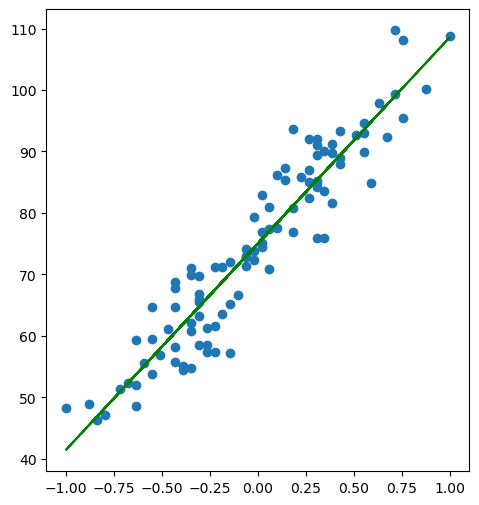

In [21]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear))

nn.fit(x, y, batch_gen=batch_shuffle, batch_size=10, epochs=1000, verbose=100)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Linear Multivariada - Exercício de Regressão do Perceptron

In [22]:
data = np.loadtxt('data/notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,:-1], data[:,-1].reshape(-1,1)
print(x.shape, y.shape)

(25, 4)
(25, 3) (25, 1)


In [23]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1. -1. -1.] [1. 1. 1.]


In [24]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear))
nn.fit(x, y, epochs=2000, verbose=200)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

epoch:    0/2000 loss_train: 10093.06169061 + 0.00000000 = 10093.06169061 loss_val = 10093.06169061
epoch:  200/2000 loss_train: 6.15003944 + 0.00000000 = 6.15003944 loss_val = 6.15003944
epoch:  400/2000 loss_train: 3.78530163 + 0.00000000 = 3.78530163 loss_val = 3.78530163
epoch:  600/2000 loss_train: 3.15331780 + 0.00000000 = 3.15331780 loss_val = 3.15331780
epoch:  800/2000 loss_train: 2.96737908 + 0.00000000 = 2.96737908 loss_val = 2.96737908
epoch: 1000/2000 loss_train: 2.90629106 + 0.00000000 = 2.90629106 loss_val = 2.90629106
epoch: 1200/2000 loss_train: 2.88404980 + 0.00000000 = 2.88404980 loss_val = 2.88404980
epoch: 1400/2000 loss_train: 2.87529044 + 0.00000000 = 2.87529044 loss_val = 2.87529044
epoch: 1600/2000 loss_train: 2.87165879 + 0.00000000 = 2.87165879 loss_val = 2.87165879
epoch: 1800/2000 loss_train: 2.87010686 + 0.00000000 = 2.87010686 loss_val = 2.87010686
epoch: 2000/2000 loss_train: 2.86943250 + 0.00000000 = 2.86943250 loss_val = 2.86943250
[[ 8.90401 13.99782 

### Regressão Quadrática

In [25]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [26]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/3000 loss_train: 1119.20212364 + 0.00000000 = 1119.20212364 loss_val = 1119.20212364
epoch:  300/3000 loss_train: 23.23840914 + 0.00000000 = 23.23840914 loss_val = 23.23840914
epoch:  600/3000 loss_train: 17.30891567 + 0.00000000 = 17.30891567 loss_val = 17.30891567
epoch:  900/3000 loss_train: 15.67176827 + 0.00000000 = 15.67176827 loss_val = 15.67176827
epoch: 1200/3000 loss_train: 14.95413780 + 0.00000000 = 14.95413780 loss_val = 14.95413780
epoch: 1500/3000 loss_train: 14.55689871 + 0.00000000 = 14.55689871 loss_val = 14.55689871
epoch: 1800/3000 loss_train: 14.31384351 + 0.00000000 = 14.31384351 loss_val = 14.31384351
epoch: 2100/3000 loss_train: 14.14299099 + 0.00000000 = 14.14299099 loss_val = 14.14299099
epoch: 2400/3000 loss_train: 14.74128959 + 0.00000000 = 14.74128959 loss_val = 14.74128959
epoch: 2700/3000 loss_train: 14.06337291 + 0.00000000 = 14.06337291 loss_val = 14.06337291
epoch: 3000/3000 loss_train: 13.94884666 + 0.00000000 = 13.94884666 loss_val = 13.94

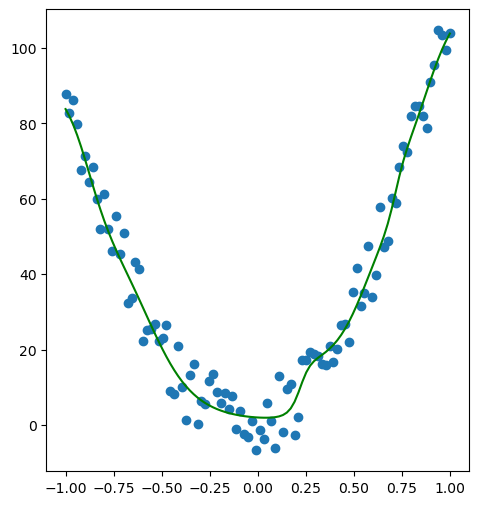

In [27]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=3000, verbose=300)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Cúbica

In [28]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [29]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/1000 loss_train: 66.60063239 + 0.00000000 = 66.60063239 loss_val = 66.60063239
epoch:  100/1000 loss_train: 35.03850565 + 0.00000000 = 35.03850565 loss_val = 35.03850565
epoch:  200/1000 loss_train: 28.28410642 + 0.00000000 = 28.28410642 loss_val = 28.28410642
epoch:  300/1000 loss_train: 15.90735811 + 0.00000000 = 15.90735811 loss_val = 15.90735811
epoch:  400/1000 loss_train: 9.04397301 + 0.00000000 = 9.04397301 loss_val = 9.04397301
epoch:  500/1000 loss_train: 5.98376020 + 0.00000000 = 5.98376020 loss_val = 5.98376020
epoch:  600/1000 loss_train: 4.47394849 + 0.00000000 = 4.47394849 loss_val = 4.47394849
epoch:  700/1000 loss_train: 3.63566382 + 0.00000000 = 3.63566382 loss_val = 3.63566382
epoch:  800/1000 loss_train: 3.13781452 + 0.00000000 = 3.13781452 loss_val = 3.13781452
epoch:  900/1000 loss_train: 2.81619758 + 0.00000000 = 2.81619758 loss_val = 2.81619758
epoch: 1000/1000 loss_train: 2.57749364 + 0.00000000 = 2.57749364 loss_val = 2.57749364


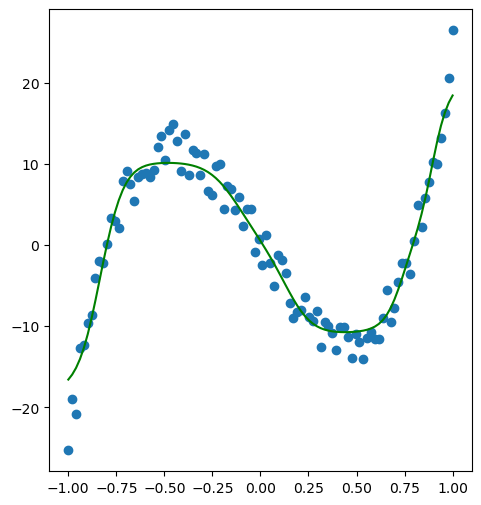

In [30]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

In [31]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [32]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/1000 loss_train: 0.54432619 + 0.00000000 = 0.54432619 loss_val = 0.54432619
epoch:  100/1000 loss_train: 0.02096869 + 0.00000000 = 0.02096869 loss_val = 0.02096869
epoch:  200/1000 loss_train: 0.01869593 + 0.00000000 = 0.01869593 loss_val = 0.01869593
epoch:  300/1000 loss_train: 0.01773059 + 0.00000000 = 0.01773059 loss_val = 0.01773059
epoch:  400/1000 loss_train: 0.01749235 + 0.00000000 = 0.01749235 loss_val = 0.01749235
epoch:  500/1000 loss_train: 0.01731247 + 0.00000000 = 0.01731247 loss_val = 0.01731247
epoch:  600/1000 loss_train: 0.01715450 + 0.00000000 = 0.01715450 loss_val = 0.01715450
epoch:  700/1000 loss_train: 0.01700660 + 0.00000000 = 0.01700660 loss_val = 0.01700660
epoch:  800/1000 loss_train: 0.01686291 + 0.00000000 = 0.01686291 loss_val = 0.01686291
epoch:  900/1000 loss_train: 0.01672122 + 0.00000000 = 0.01672122 loss_val = 0.01672122
epoch: 1000/1000 loss_train: 0.01658132 + 0.00000000 = 0.01658132 loss_val = 0.01658132


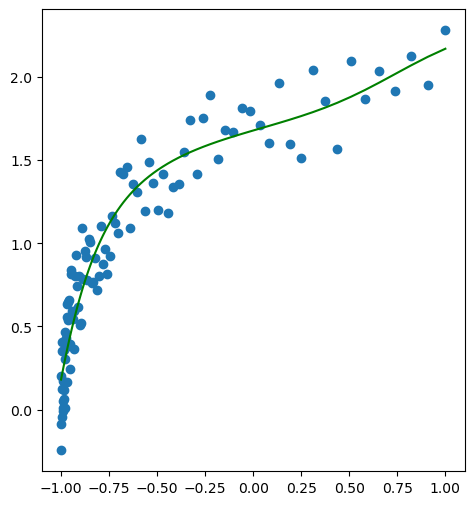

In [33]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Exponencial

In [34]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [35]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/1000 loss_train: 833.00904574 + 0.00000000 = 833.00904574 loss_val = 833.00904574
epoch:  100/1000 loss_train: 22.35021248 + 0.00000000 = 22.35021248 loss_val = 22.35021248
epoch:  200/1000 loss_train: 16.76643312 + 0.00000000 = 16.76643312 loss_val = 16.76643312
epoch:  300/1000 loss_train: 15.64265430 + 0.00000000 = 15.64265430 loss_val = 15.64265430
epoch:  400/1000 loss_train: 15.52273451 + 0.00000000 = 15.52273451 loss_val = 15.52273451
epoch:  500/1000 loss_train: 15.45003120 + 0.00000000 = 15.45003120 loss_val = 15.45003120
epoch:  600/1000 loss_train: 15.39413912 + 0.00000000 = 15.39413912 loss_val = 15.39413912
epoch:  700/1000 loss_train: 15.34060448 + 0.00000000 = 15.34060448 loss_val = 15.34060448
epoch:  800/1000 loss_train: 15.28484066 + 0.00000000 = 15.28484066 loss_val = 15.28484066
epoch:  900/1000 loss_train: 15.25957038 + 0.00000000 = 15.25957038 loss_val = 15.25957038
epoch: 1000/1000 loss_train: 15.16911824 + 0.00000000 = 15.16911824 loss_val = 15.16911

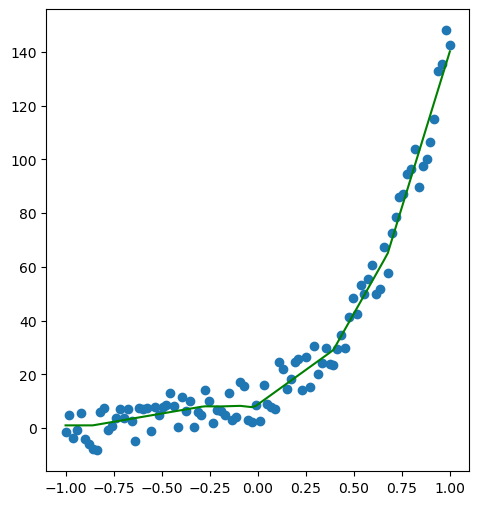

In [36]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

## Classificação Binária

### Porta AND/OR

In [37]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/1000 loss_train: 0.89254382 + 0.01683532 = 0.90937913 loss_val = 0.89254382
epoch:  100/1000 loss_train: 0.17501697 + 0.06464098 = 0.23965795 loss_val = 0.17501697
epoch:  200/1000 loss_train: 0.11293148 + 0.08807453 = 0.20100601 loss_val = 0.11293148
epoch:  300/1000 loss_train: 0.08857572 + 0.10088201 = 0.18945773 loss_val = 0.08857572
epoch:  400/1000 loss_train: 0.07593757 + 0.10893515 = 0.18487272 loss_val = 0.07593757
epoch:  500/1000 loss_train: 0.06843846 + 0.11435157 = 0.18279004 loss_val = 0.06843846
epoch:  600/1000 loss_train: 0.06362614 + 0.11814097 = 0.18176712 loss_val = 0.06362614
epoch:  700/1000 loss_train: 0.06037907 + 0.12085995 = 0.18123902 loss_val = 0.06037907
epoch:  800/1000 loss_train: 0.05811251 + 0.12284454 = 0.18095705 loss_val = 0.05811251
epoch:  900/1000 loss_train: 0.05649234 + 0.12431058 = 0.18080293 loss_val = 0.05649234
epoch: 1000/1000 loss_train: 0.05531433 + 0.12540292 = 0.18071725 loss_val = 0.05531433
[[5.01612 5.01612]] [[-7.88934]]

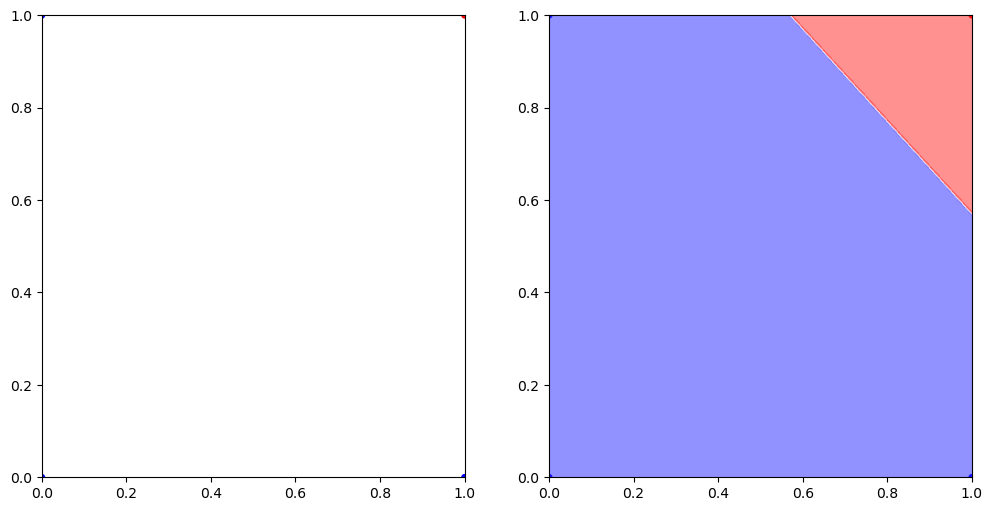

In [38]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear, reg_func=l1_regularization, reg_strength=0.05))

nn.fit(x, y, epochs=1000, verbose=100)

print(nn.layers[0].weights, nn.layers[0].biases)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, cmap='bwr')

### Porta XOR

In [39]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/1000 loss_train: 0.67827202 + 0.00000000 = 0.67827202 loss_val = 0.67827202
epoch:  100/1000 loss_train: 0.51341320 + 0.00000000 = 0.51341320 loss_val = 0.51341320
epoch:  200/1000 loss_train: 0.16821956 + 0.00000000 = 0.16821956 loss_val = 0.16821956
epoch:  300/1000 loss_train: 0.06898962 + 0.00000000 = 0.06898962 loss_val = 0.06898962
epoch:  400/1000 loss_train: 0.04177614 + 0.00000000 = 0.04177614 loss_val = 0.04177614
epoch:  500/1000 loss_train: 0.02963817 + 0.00000000 = 0.02963817 loss_val = 0.02963817
epoch:  600/1000 loss_train: 0.02285611 + 0.00000000 = 0.02285611 loss_val = 0.02285611
epoch:  700/1000 loss_train: 0.01855220 + 0.00000000 = 0.01855220 loss_val = 0.01855220
epoch:  800/1000 loss_train: 0.01558815 + 0.00000000 = 0.01558815 loss_val = 0.01558815
epoch:  900/1000 loss_train: 0.01342717 + 0.00000000 = 0.01342717 loss_val = 0.01342717
epoch: 1000/1000 loss_train: 0.01178415 + 0.00000000 = 0.01178415 loss_val = 0.01178415
Predições:
[[-4.46549]
 [ 4.1904

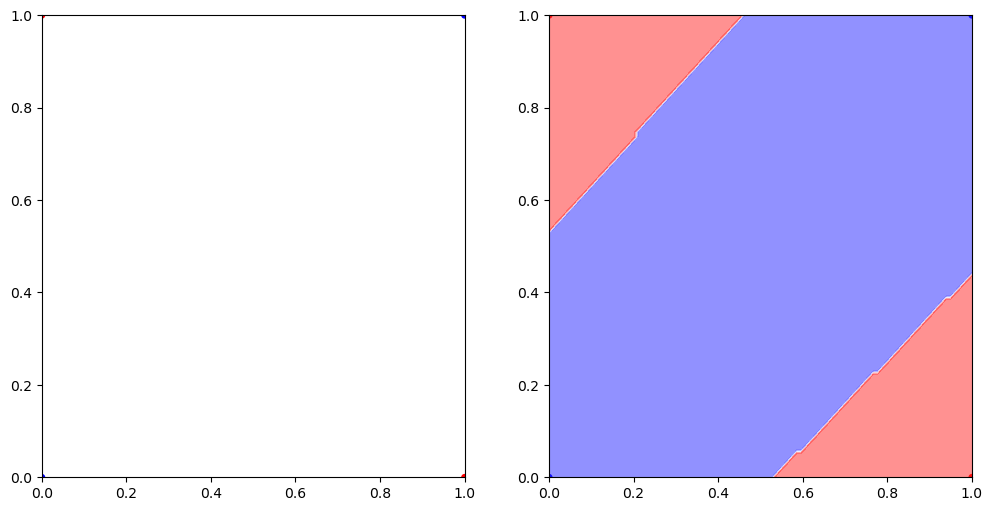

In [40]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, cmap='bwr')

### 2 Clusters

In [41]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(100, 2) (100, 1)


epoch:    0/5000 loss_train: 0.42351585 + 0.00000000 = 0.42351585 loss_val = 0.42351585
epoch: 1000/5000 loss_train: 0.00616226 + 0.00000000 = 0.00616226 loss_val = 0.00616226
epoch: 2000/5000 loss_train: 0.00415785 + 0.00000000 = 0.00415785 loss_val = 0.00415785
epoch: 3000/5000 loss_train: 0.00330179 + 0.00000000 = 0.00330179 loss_val = 0.00330179
epoch: 4000/5000 loss_train: 0.00279754 + 0.00000000 = 0.00279754 loss_val = 0.00279754
epoch: 5000/5000 loss_train: 0.00245491 + 0.00000000 = 0.00245491 loss_val = 0.00245491
Acurácia: 100.00%


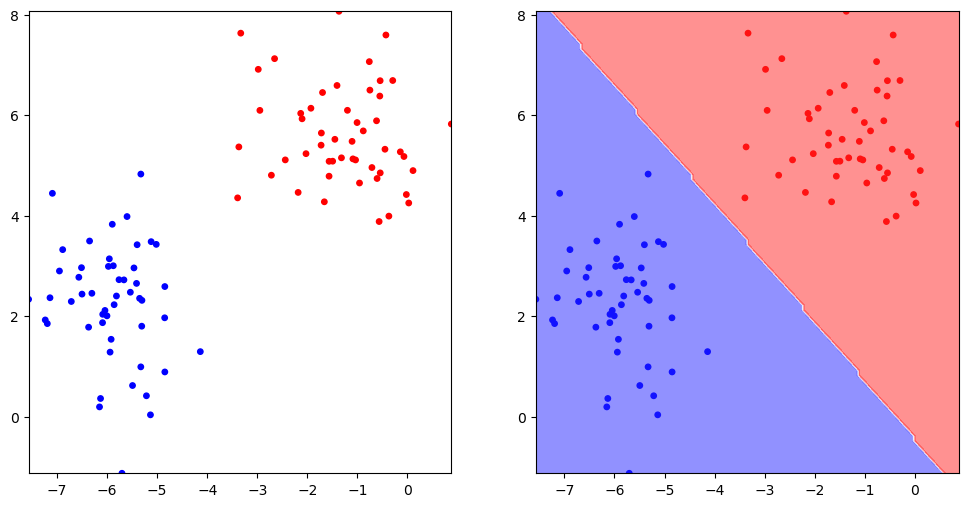

In [42]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

y_pred = nn.predict(x)

threshold = 0 if nn.layers[-1].activation == linear else 0.5
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred >= threshold)))
plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=threshold, cmap='bwr')

### 4 Clusters

In [43]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)

(500, 2) (500, 1)


epoch:    0/500 loss_train: 0.99105985 + 0.00000000 = 0.99105985 loss_val = 0.99105985
epoch:  100/500 loss_train: 0.00013066 + 0.00000000 = 0.00013066 loss_val = 0.00013066
epoch:  200/500 loss_train: 0.00009900 + 0.00000000 = 0.00009900 loss_val = 0.00009900
epoch:  300/500 loss_train: 0.00008019 + 0.00000000 = 0.00008019 loss_val = 0.00008019
epoch:  400/500 loss_train: 0.00006763 + 0.00000000 = 0.00006763 loss_val = 0.00006763
epoch:  500/500 loss_train: 0.00005864 + 0.00000000 = 0.00005864 loss_val = 0.00005864
Acurácia: 100.00%


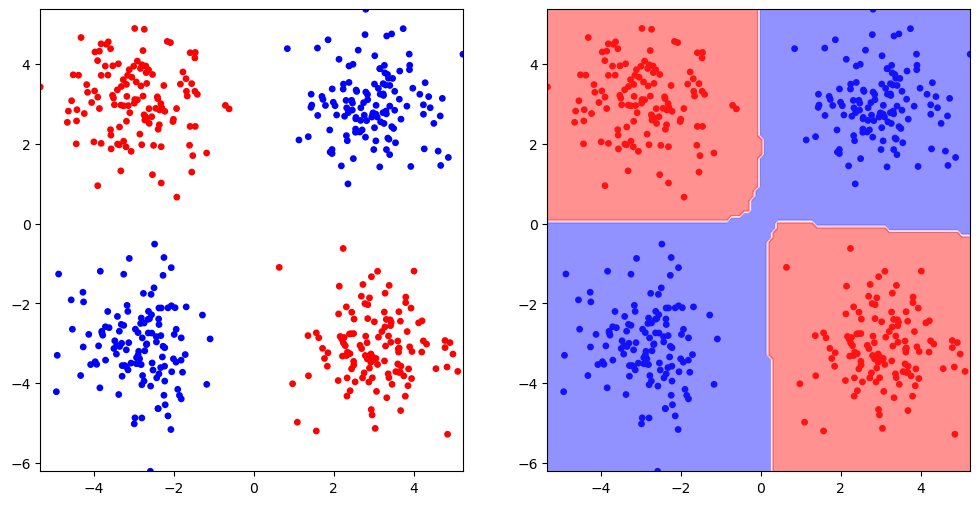

In [44]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=500, verbose=100)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Círculos

In [45]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(500, 2) (500, 1)


epoch:    0/1000 loss_train: 0.66282107 + 0.00000000 = 0.66282107 loss_val = 0.66282107
epoch:  100/1000 loss_train: 0.01389453 + 0.00000000 = 0.01389453 loss_val = 0.01389453
epoch:  200/1000 loss_train: 0.00654334 + 0.00000000 = 0.00654334 loss_val = 0.00654334
epoch:  300/1000 loss_train: 0.00432619 + 0.00000000 = 0.00432619 loss_val = 0.00432619
epoch:  400/1000 loss_train: 0.00322687 + 0.00000000 = 0.00322687 loss_val = 0.00322687
epoch:  500/1000 loss_train: 0.00256463 + 0.00000000 = 0.00256463 loss_val = 0.00256463
epoch:  600/1000 loss_train: 0.00211802 + 0.00000000 = 0.00211802 loss_val = 0.00211802
epoch:  700/1000 loss_train: 0.00179619 + 0.00000000 = 0.00179619 loss_val = 0.00179619
epoch:  800/1000 loss_train: 0.00155365 + 0.00000000 = 0.00155365 loss_val = 0.00155365
epoch:  900/1000 loss_train: 0.00136275 + 0.00000000 = 0.00136275 loss_val = 0.00136275
epoch: 1000/1000 loss_train: 0.00120689 + 0.00000000 = 0.00120689 loss_val = 0.00120689
Acurácia: 100.00%


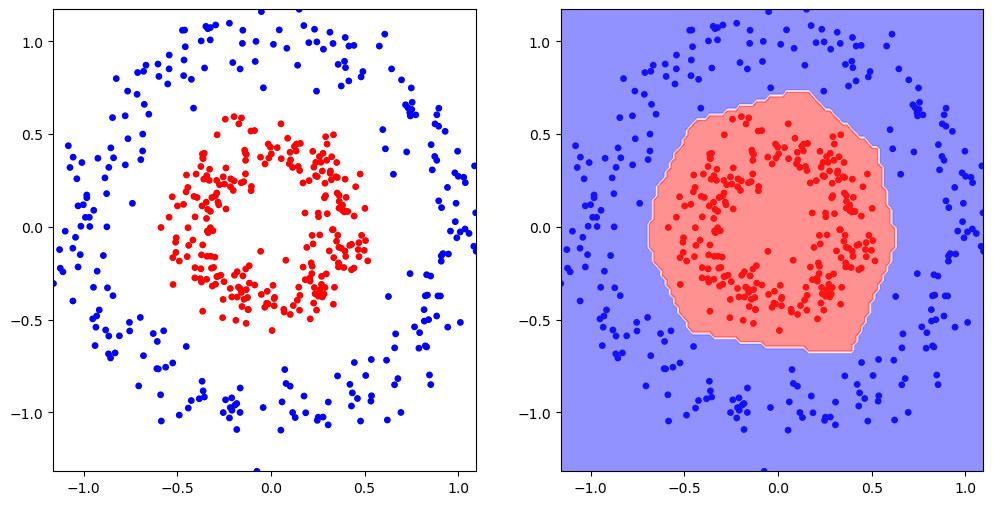

In [46]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=8, activation=relu))
nn.layers.append(Layer(input_dim=8, output_dim=8, activation=relu))
nn.layers.append(Layer(input_dim=8, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=1000, verbose=100)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Moons

In [47]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(200, 2) (200, 1)


epoch:    0/2000 loss_train: 0.85956269 + 0.00000000 = 0.85956269 loss_val = 0.85956269
epoch:  200/2000 loss_train: 0.29935686 + 0.00000000 = 0.29935686 loss_val = 0.29935686
epoch:  400/2000 loss_train: 0.29775132 + 0.00000000 = 0.29775132 loss_val = 0.29775132
epoch:  600/2000 loss_train: 0.29604732 + 0.00000000 = 0.29604732 loss_val = 0.29604732
epoch:  800/2000 loss_train: 0.29411209 + 0.00000000 = 0.29411209 loss_val = 0.29411209
epoch: 1000/2000 loss_train: 0.29152297 + 0.00000000 = 0.29152297 loss_val = 0.29152297
epoch: 1200/2000 loss_train: 0.28434798 + 0.00000000 = 0.28434798 loss_val = 0.28434798
epoch: 1400/2000 loss_train: 0.23658613 + 0.00000000 = 0.23658613 loss_val = 0.23658613
epoch: 1600/2000 loss_train: 0.11411262 + 0.00000000 = 0.11411262 loss_val = 0.11411262
epoch: 1800/2000 loss_train: 0.08920219 + 0.00000000 = 0.08920219 loss_val = 0.08920219
epoch: 2000/2000 loss_train: 0.08281030 + 0.00000000 = 0.08281030 loss_val = 0.08281030
Acurácia: 97.50%


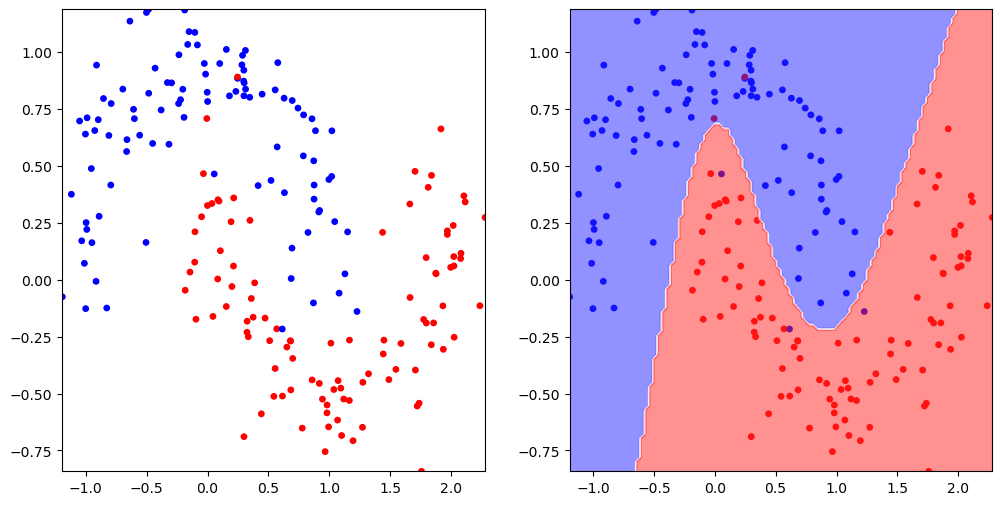

In [48]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=tanh))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=2000, verbose=200)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Espiral

In [49]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(200, 2) (200, 1)


epoch:    0/5000 loss_train: 2.12331667 + 0.00000000 = 2.12331667 loss_val = 2.12331667
epoch:  500/5000 loss_train: 0.15912755 + 0.00000000 = 0.15912755 loss_val = 0.15912755
epoch: 1000/5000 loss_train: 0.05478049 + 0.00000000 = 0.05478049 loss_val = 0.05478049
epoch: 1500/5000 loss_train: 0.02217535 + 0.00000000 = 0.02217535 loss_val = 0.02217535
epoch: 2000/5000 loss_train: 0.02117657 + 0.00000000 = 0.02117657 loss_val = 0.02117657
epoch: 2500/5000 loss_train: 0.01081963 + 0.00000000 = 0.01081963 loss_val = 0.01081963
epoch: 3000/5000 loss_train: 0.00889054 + 0.00000000 = 0.00889054 loss_val = 0.00889054
epoch: 3500/5000 loss_train: 0.00846030 + 0.00000000 = 0.00846030 loss_val = 0.00846030
epoch: 4000/5000 loss_train: 0.00924154 + 0.00000000 = 0.00924154 loss_val = 0.00924154
epoch: 4500/5000 loss_train: 0.00738252 + 0.00000000 = 0.00738252 loss_val = 0.00738252
epoch: 5000/5000 loss_train: 0.00770495 + 0.00000000 = 0.00770495 loss_val = 0.00770495
Acurácia: 99.50%


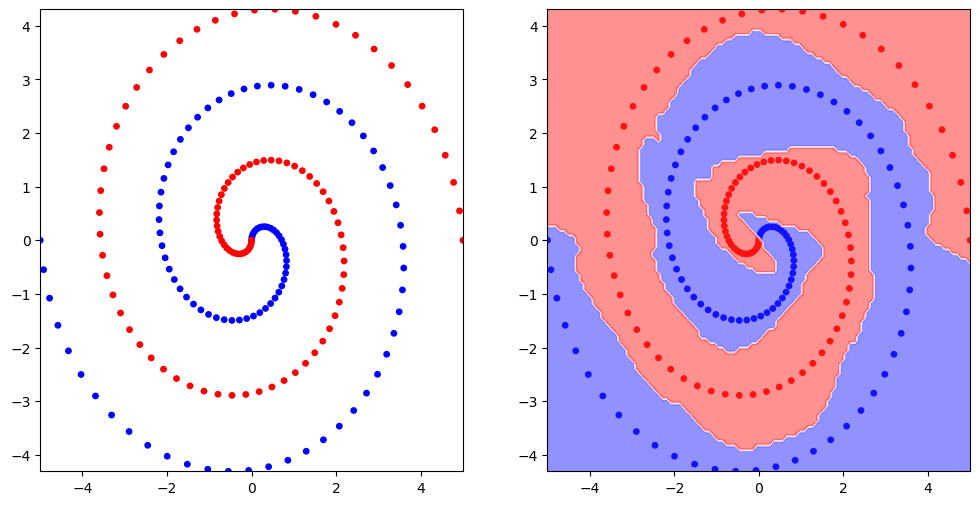

In [50]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=tanh, dropout_prob=0.25))
nn.layers.append(Layer(input_dim=20, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=500)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

## Classificação Multiclasse

### 3 Clusters Multiclasse

In [51]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(300, 2) (300, 1)


In [52]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::60])

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


/Users/arnaldo/mambaforge/envs/mpdl/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


epoch:    0/1000 loss_train: 1.26802784 + 0.00200670 = 1.27003454 loss_val = 1.26802784
epoch:  100/1000 loss_train: 0.08827718 + 0.00793354 = 0.09621071 loss_val = 0.08827718
epoch:  200/1000 loss_train: 0.04187947 + 0.00745556 = 0.04933503 loss_val = 0.04187947
epoch:  300/1000 loss_train: 0.02687172 + 0.00702362 = 0.03389535 loss_val = 0.02687172
epoch:  400/1000 loss_train: 0.01968640 + 0.00663180 = 0.02631820 loss_val = 0.01968640
epoch:  500/1000 loss_train: 0.01551034 + 0.00627175 = 0.02178209 loss_val = 0.01551034
epoch:  600/1000 loss_train: 0.01279329 + 0.00593887 = 0.01873217 loss_val = 0.01279329
epoch:  700/1000 loss_train: 0.01089136 + 0.00563075 = 0.01652212 loss_val = 0.01089136
epoch:  800/1000 loss_train: 0.00949039 + 0.00534607 = 0.01483646 loss_val = 0.00949039
epoch:  900/1000 loss_train: 0.00841911 + 0.00508402 = 0.01350314 loss_val = 0.00841911
epoch: 1000/1000 loss_train: 0.00757612 + 0.00484399 = 0.01242011 loss_val = 0.00757612
[[-2.94496  0.32459]
 [-0.31998 

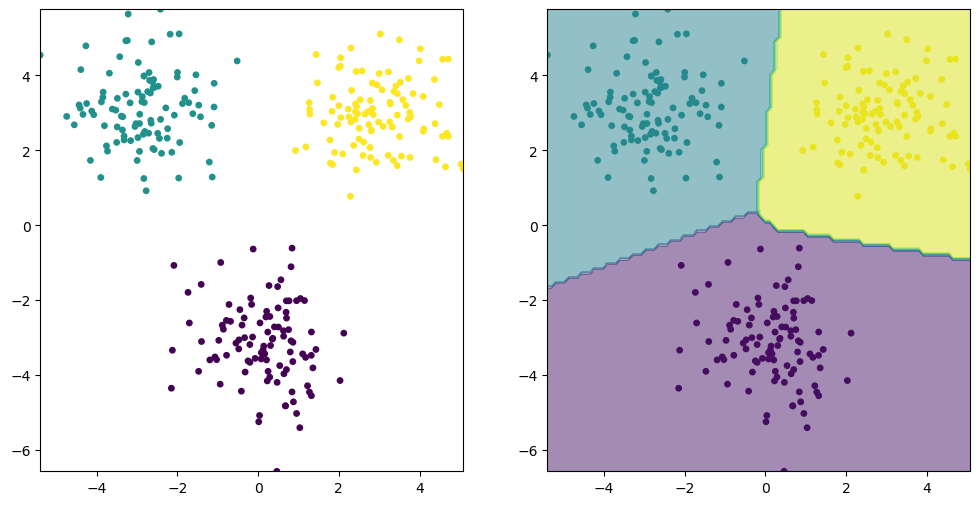

In [53]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=relu, reg_func=l2_regularization, reg_strength=0.1))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=linear, reg_func=l2_regularization, reg_strength=0.1))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

for layer in nn.layers:
    print(layer.weights)
    
y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### 4 Clusters Multiclasse

In [54]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(400, 2) (400, 1)


In [55]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::70])

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


/Users/arnaldo/mambaforge/envs/mpdl/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


epoch:    0/1000 loss_train: 4.86623544 + 0.00000000 = 4.86623544 loss_val = 4.86623544
epoch:  100/1000 loss_train: 0.10644559 + 0.00000000 = 0.10644559 loss_val = 0.10644559
epoch:  200/1000 loss_train: 0.09317528 + 0.00000000 = 0.09317528 loss_val = 0.09317528
epoch:  300/1000 loss_train: 0.08551505 + 0.00000000 = 0.08551505 loss_val = 0.08551505
epoch:  400/1000 loss_train: 0.08352825 + 0.00000000 = 0.08352825 loss_val = 0.08352825
epoch:  500/1000 loss_train: 0.08215603 + 0.00000000 = 0.08215603 loss_val = 0.08215603
epoch:  600/1000 loss_train: 0.08105392 + 0.00000000 = 0.08105392 loss_val = 0.08105392
epoch:  700/1000 loss_train: 0.08010279 + 0.00000000 = 0.08010279 loss_val = 0.08010279
epoch:  800/1000 loss_train: 0.07927047 + 0.00000000 = 0.07927047 loss_val = 0.07927047
epoch:  900/1000 loss_train: 0.07853538 + 0.00000000 = 0.07853538 loss_val = 0.07853538
epoch: 1000/1000 loss_train: 0.07787776 + 0.00000000 = 0.07787776 loss_val = 0.07787776
Acurácia: 97.25%


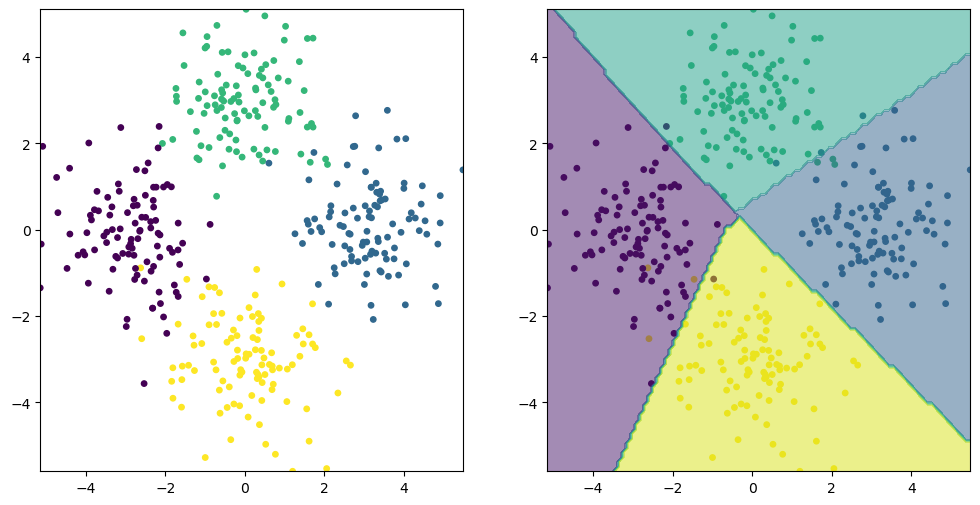

In [56]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Espiral - 5 Classes

In [57]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(500, 2) (500, 1)


In [58]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::100])

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


/Users/arnaldo/mambaforge/envs/mpdl/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


epoch:    0/2000 loss_train: 3.06700987 + 0.00000000 = 3.06700987 loss_val = 3.06700987
epoch:  200/2000 loss_train: 0.77423937 + 0.00000000 = 0.77423937 loss_val = 0.77423937
epoch:  400/2000 loss_train: 0.62581258 + 0.00000000 = 0.62581258 loss_val = 0.62581258
epoch:  600/2000 loss_train: 0.51441300 + 0.00000000 = 0.51441300 loss_val = 0.51441300
epoch:  800/2000 loss_train: 0.42831931 + 0.00000000 = 0.42831931 loss_val = 0.42831931
epoch: 1000/2000 loss_train: 0.36349660 + 0.00000000 = 0.36349660 loss_val = 0.36349660
epoch: 1200/2000 loss_train: 0.30538857 + 0.00000000 = 0.30538857 loss_val = 0.30538857
epoch: 1400/2000 loss_train: 0.35392408 + 0.00000000 = 0.35392408 loss_val = 0.35392408
epoch: 1600/2000 loss_train: 0.25519669 + 0.00000000 = 0.25519669 loss_val = 0.25519669
epoch: 1800/2000 loss_train: 0.26777970 + 0.00000000 = 0.26777970 loss_val = 0.26777970
epoch: 2000/2000 loss_train: 0.18997244 + 0.00000000 = 0.18997244 loss_val = 0.18997244
Acurácia: 92.20%


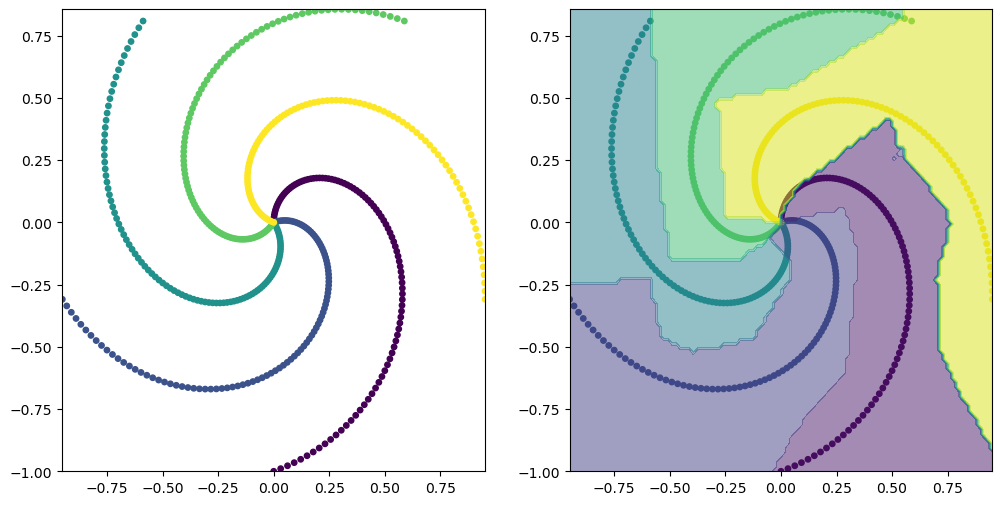

In [59]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=2000, verbose=200)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Make Classification - 4 Classes

In [60]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(100, 2) (100, 1)


In [61]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::10])

[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


/Users/arnaldo/mambaforge/envs/mpdl/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


epoch:    0/1000 loss_train: 2.72132157 + 0.00000000 = 2.72132157 loss_val = 2.72132157
epoch:  100/1000 loss_train: 0.20282021 + 0.00000000 = 0.20282021 loss_val = 0.20282021
epoch:  200/1000 loss_train: 0.17208266 + 0.00000000 = 0.17208266 loss_val = 0.17208266
epoch:  300/1000 loss_train: 0.15267028 + 0.00000000 = 0.15267028 loss_val = 0.15267028
epoch:  400/1000 loss_train: 0.14099957 + 0.00000000 = 0.14099957 loss_val = 0.14099957
epoch:  500/1000 loss_train: 0.13178095 + 0.00000000 = 0.13178095 loss_val = 0.13178095
epoch:  600/1000 loss_train: 0.12432234 + 0.00000000 = 0.12432234 loss_val = 0.12432234
epoch:  700/1000 loss_train: 0.11827423 + 0.00000000 = 0.11827423 loss_val = 0.11827423
epoch:  800/1000 loss_train: 0.11298294 + 0.00000000 = 0.11298294 loss_val = 0.11298294
epoch:  900/1000 loss_train: 0.10851839 + 0.00000000 = 0.10851839 loss_val = 0.10851839
epoch: 1000/1000 loss_train: 0.10464264 + 0.00000000 = 0.10464264 loss_val = 0.10464264
Acurácia: 95.00%


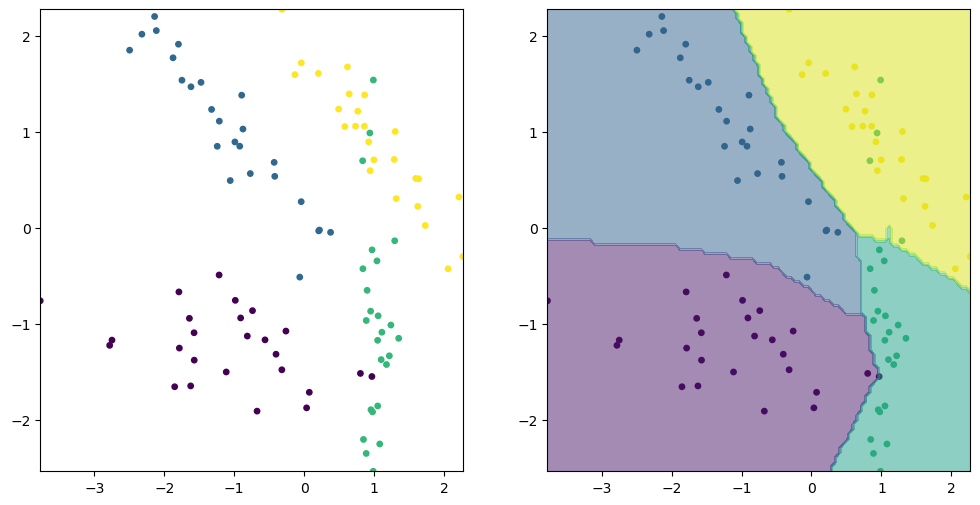

In [62]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Iris Dataset

In [63]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


In [64]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


/Users/arnaldo/mambaforge/envs/mpdl/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


epoch:    0/2000 loss_train: 0.90293822 + 0.00000000 = 0.90293822 loss_val = 0.90293822
epoch:  200/2000 loss_train: 0.68115782 + 0.00000000 = 0.68115782 loss_val = 0.68115782
epoch:  400/2000 loss_train: 0.61516859 + 0.00000000 = 0.61516859 loss_val = 0.61516859
epoch:  600/2000 loss_train: 0.57816022 + 0.00000000 = 0.57816022 loss_val = 0.57816022
epoch:  800/2000 loss_train: 0.55479995 + 0.00000000 = 0.55479995 loss_val = 0.55479995
epoch: 1000/2000 loss_train: 0.53888008 + 0.00000000 = 0.53888008 loss_val = 0.53888008
epoch: 1200/2000 loss_train: 0.52740770 + 0.00000000 = 0.52740770 loss_val = 0.52740770
epoch: 1400/2000 loss_train: 0.51873742 + 0.00000000 = 0.51873742 loss_val = 0.51873742
epoch: 1600/2000 loss_train: 0.51191371 + 0.00000000 = 0.51191371 loss_val = 0.51191371
epoch: 1800/2000 loss_train: 0.50631368 + 0.00000000 = 0.50631368 loss_val = 0.50631368
epoch: 2000/2000 loss_train: 0.50117457 + 0.00000000 = 0.50117457 loss_val = 0.50117457
Acurácia: 74.00%


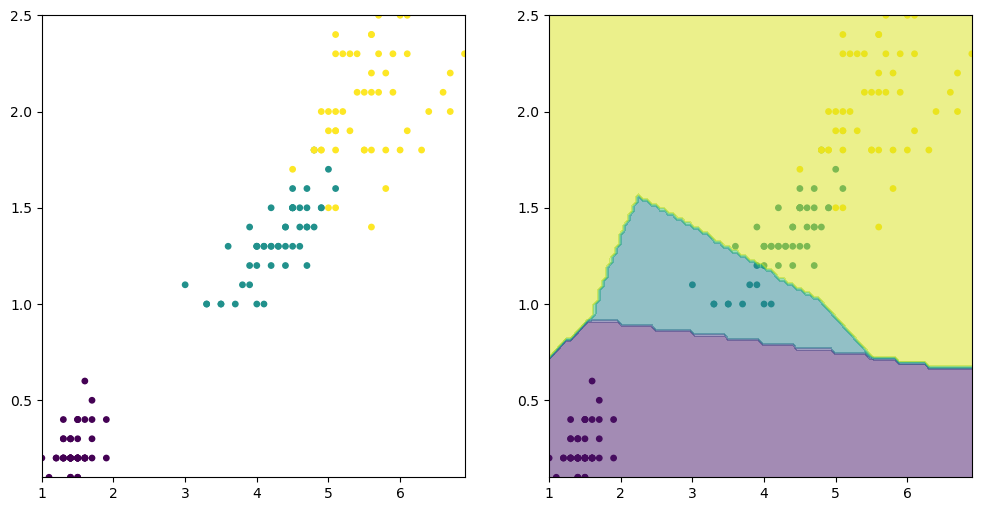

In [65]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=2000, verbose=200)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

# Referências

- [Tensorflow Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.94880&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

- [Linear Classification](http://cs231n.github.io/linear-classify/)

__Regularization__:
- [Implementing Neural Network L1 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/27/implementing-neural-network-l1-regularization/)
- [Implementing Neural Network L2 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/29/implementing-neural-network-l2-regularization/)
- [Neural Network L2 Regularization Using Python](https://visualstudiomagazine.com/articles/2017/09/01/neural-network-l2.aspx)

__Momentum__:
- [Neural Network Momentum Using Python](https://visualstudiomagazine.com/articles/2017/08/01/neural-network-momentum.aspx)
- [Beyond SGD: Gradient Descent with Momentum and Adaptive Learning Rate](https://wiseodd.github.io/techblog/2016/06/22/nn-optimization/)

__Learning Rate Decay__:
- [Using Learning Rate Schedules for Deep Learning Models in Python with Keras](https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)
- [Learning Rate Schedules and Adaptive Learning Rate Methods for Deep Learning](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)
- [Tensorflow Exponential Decay Documentation](https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay)

__Batch Normalization__:
- [Understanding the backward pass through Batch Normalization Layer](https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html)
- [Deriving the Gradient for the Backward Pass of Batch Normalization](https://kevinzakka.github.io/2016/09/14/batch_normalization/)
- [Implementing BatchNorm in Neural Net](https://wiseodd.github.io/techblog/2016/07/04/batchnorm/)
- [What does the gradient flowing through batch normalization looks like ?](http://cthorey.github.io./backpropagation/)
- [GRADIENTS, BATCH NORMALIZATION AND LAYER NORMALIZATION](https://theneuralperspective.com/2016/10/27/gradient-topics/)

__Gradient Checking__:
- [cs231n](https://github.com/cs231n/cs231n.github.io/blob/master/neural-networks-3.md#gradcheck)
- [Gradient checking and advanced optimization](http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization)
- [BatchNormalization fails gradient checking](https://github.com/torch/nn/issues/744)

__NOTAS__:

__Inicialização dos pesos__:
- mostrar a documentação das funções np.random.rand e np.random.randn para mostrar como gerar distribuições na faixa [-limit, limit] e com média zero e certo desvio-padrão.
- mostrar que os métodos de inicialização de pesos ones e random_uniform podem não ser adequados para alguns problemas, como o do espiral binário.

__Regularização__:
- mostrar que a regularização dos pesos nem sempre ajuda. Em alguns casos, como o espiral multiclasse, temos que definir a reg_strength muito pequena. Isto é, estamos dizendo que o valores dos pesos não podem influenciar no custo. Em outras palavras, isso é a mesma coisa que "desligar" a regularização.
- temos de ter muito cuidado ao fazer a checkagem do gradiente com regularização L1/L2. Muitas implementações esquecem de adicionar o custo da regularização na checkagem do gradiente. Isso pode fazer você pensar que a implementação está errada.

__Learning Rate Decay__:
- mostrar que a staircase_decay e exponential_decay tem praticamente a mesma fórmula, com exceção de decay_steps. Na própria documentação do Tensorflow, eles implementam as duas no mesmo método.